In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F  # Import functional module
import time
import pandas as pd


In [40]:
X_train = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/x_train.csv') # every row is an image vector
y_train = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/y_train.csv')
X_test = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/x_test.csv')
y_test = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/y_test.csv')


In [41]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNClassifier, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # 3x3 filter
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)  # 3x3 filter
        
        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 196, 512)  # Adjusted for the flattened size after pooling
        
        # Output Layer (Softmax will be applied outside the model during loss computation)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # First convolutional layer
        x = self.pool(x)  # Max pooling
        x = self.relu(self.conv2(x))  # Second convolutional layer
        x = self.pool(x)  # Max pooling again
        
        x = x.view(-1, 32 * 196)  # Flatten the output for the fully connected layer
        x = self.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Output layer
        
        return x

In [42]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Convert X_train to tensor
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).squeeze()  # Convert y_train to tensor (for classification tasks)

# Create a TensorDataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [43]:
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Convert X_test to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()  # Convert y_test to tensor (for classification tasks)

# Create a TensorDataset
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [44]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [45]:
# Model, optimizer, loss function
model = CNNClassifier(num_classes=5).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [46]:
num_epochs = 1000

In [47]:
print(torch.min(y_train_tensor), torch.max(y_train_tensor))


tensor(0) tensor(4)


In [48]:
def train_model(model, optimizer, criterion, num_epochs):
    training_losses = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move input and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        training_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    return model, training_losses, num_epochs 

In [49]:
model, training_losses, epochs = train_model(model, optimizer, criterion, num_epochs=100)


Epoch 1/100, Loss: 0.3384978710443247
Epoch 2/100, Loss: 0.07292146743974494
Epoch 3/100, Loss: 0.06341988325541606
Epoch 4/100, Loss: 0.05475976297503027
Epoch 5/100, Loss: 0.048512435541733914
Epoch 6/100, Loss: 0.038753670346668996
Epoch 7/100, Loss: 0.034288628141535084
Epoch 8/100, Loss: 0.02953148145840437
Epoch 9/100, Loss: 0.024469955672252207
Epoch 10/100, Loss: 0.021396778566575767
Epoch 11/100, Loss: 0.02012100278039443
Epoch 12/100, Loss: 0.01780854191157416
Epoch 13/100, Loss: 0.01610257409360381
Epoch 14/100, Loss: 0.015744774512465944
Epoch 15/100, Loss: 0.012235270298601891
Epoch 16/100, Loss: 0.013043985242923445
Epoch 17/100, Loss: 0.010717680167049567
Epoch 18/100, Loss: 0.009651096463390366
Epoch 19/100, Loss: 0.01198875034748159
Epoch 20/100, Loss: 0.012340284555510103
Epoch 21/100, Loss: 0.010228555744091226
Epoch 22/100, Loss: 0.010460588575464173
Epoch 23/100, Loss: 0.008725998318976148
Epoch 24/100, Loss: 0.0027286938862765685
Epoch 25/100, Loss: 0.012598726284

In [51]:
import matplotlib.pyplot as plt

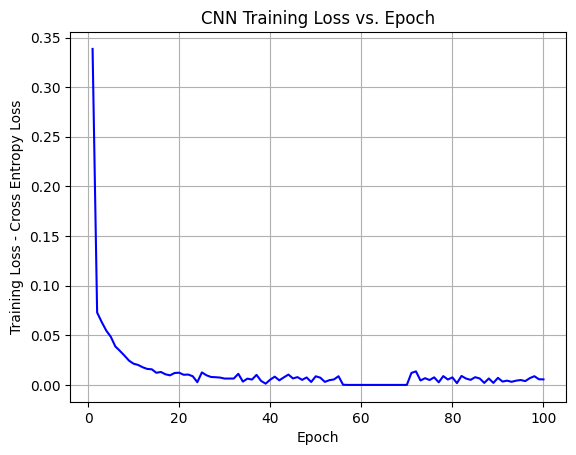

In [54]:
plt.plot(range(1, epochs+1), training_losses, linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Training Loss - Cross Entropy Loss")
plt.title("CNN Training Loss vs. Epoch")
plt.grid()
plt.show()

In [58]:
# After training, you can test your model
def eval_model(model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during testing
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probabilities = F.softmax(outputs, dim=1) # apply softmax 

            _, predicted = torch.max(probabilities, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

        print(f"ACCURACY: {100 * correct / total}%")

In [59]:
eval_model(model)

ACCURACY: 98.2%


In [90]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        # flatten 'x' here before passing into first layer
        # Reshape (10000, 1, 784) -> (10000, 1, 28, 28)
        x = x.view(-1, 1, 28, 28) 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [91]:
# Model, optimizer, loss function
vgg16_model = VGG16(num_classes=5).to(device)  # Move model to GPU
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
vgg16_model, training_losses_vgg, epochs = train_model(vgg16_model, optimizer, criterion, 100)

Epoch 1/100, Loss: 0.13809500535540284
Epoch 2/100, Loss: 0.10622701623023798


- [vgg16 CNN model](https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55) 
- [research paper link](https://arxiv.org/abs/1409.1556)
- [pdf link](https://arxiv.org/pdf/1409.1556)